In [2]:
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import aquarel as aq
from ineqpy.inequality import gini
import scipy.stats as st
import pyalex as alex
alex.config.email = "noah0roussel01980@gmail.com"
works = pl.read_csv("../../../data/works/works_q1.csv")
works = works.filter(pl.col("year") != 2025)

year_begin = 1920
year_end = 2024
works = works.with_columns(
    age=2025 - pl.col("year")
)




In [3]:
cbc_per_year = (
    works
    .select(
        [pl.col("year"), pl.col("cited_by_count"), pl.col("title")]
    )
    .group_by(
        pl.col("year"),
        maintain_order=True
    )
    .agg(
        pl.col("cited_by_count").mean().name.prefix("mean_")
    )
) # number of citations (cbc = cited by count) of the works published a given year

works = works.join(
    cbc_per_year,
    on="year",
    how="left"
) # left join

works = (
    works
    .with_columns(
        mncs = pl.col("cited_by_count") / pl.col("mean_cited_by_count")
    )
    .drop("mean_cited_by_count")
)
cols_authors = [col for col in works.columns if col.startswith("author_")]

works = works.with_columns(
    authors_count = sum(
        [pl.col(col).is_not_null().cast(pl.Int8) for col in cols_authors]
    )

)

works = works.with_columns(
    title = pl.col("title").fill_null("").str.to_lowercase(),
    abstract = pl.col("abstract").fill_null("").str.to_lowercase()
)

works = works.with_columns(
    review = (
        pl.col("title").str.contains("review") |
        pl.col("abstract").str.contains("review")
    ),
    meta_analysis = (
        pl.col("title").str.contains("meta[\u00AD-]?analysis") |
        pl.col("abstract").str.contains("meta[\u00AD-]?analysis")
    )
)

works = works.with_columns([
    pl.when(pl.col("countries_distinct_count").is_null() | pl.col("countries_distinct_count").is_nan() | (pl.col("countries_distinct_count") == 0))
      .then(1)
      .otherwise(pl.col("countries_distinct_count"))
      .alias("countries_distinct_count")
])
works = works.with_columns([
    pl.when(pl.col("institutions_distinct_count").is_null() | pl.col("institutions_distinct_count").is_nan() | (pl.col("institutions_distinct_count") == 0))
      .then(1)
      .otherwise(pl.col("institutions_distinct_count"))
      .alias("institutions_distinct_count")
])

group_year_mean = (
    works.group_by(
        by= pl.col("year"),
        maintain_order=True 
        )
        .mean()
        .select(
            ["year", "cited_by_count", "countries_distinct_count", "institutions_distinct_count", "referenced_works_count", "authors_count", "mncs"]
        )
)

group_year_mean = group_year_mean.sort(by="year", descending=True)
group_references_mean = (
    works.lazy()  # passe en mode lazy
    .filter(~pl.col("review") & ~pl.col("meta_analysis"))
    .group_by("referenced_works_count")
    .agg([
        pl.col("mncs").mean().alias("mncs"),
        pl.len().alias("count")
    ])
    .sort("referenced_works_count")
    .collect()  # exécution optimisée
)

works

title,year,cited_by_count,countries_distinct_count,institutions_distinct_count,citation_normalized_percentile,primary_topic,keywords,concepts,referenced_works_count,referenced_works,abstract,abstract_inverted_index,journal,author_1,author_2,author_3,institution_1,institution_2,institution_3,country_1,country_2,country_3,cited_by_count_2025,cited_by_count_2024,cited_by_count_2023,cited_by_count_2022,cited_by_count_2021,cited_by_count_2020,cited_by_count_2019,cited_by_count_2018,cited_by_count_2017,cited_by_count_2016,cited_by_count_2015,cited_by_count_2014,cited_by_count_2013,cited_by_count_2012,…,country_239,country_240,country_241,country_242,country_243,country_244,country_245,country_246,country_247,country_248,country_249,country_250,country_251,country_252,country_253,country_254,country_255,country_256,country_257,country_258,country_259,country_260,country_261,country_262,country_263,country_264,country_265,country_266,country_267,country_268,country_269,country_270,age,mncs,authors_count,review,meta_analysis
str,i64,i64,i64,i64,str,str,str,str,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i64,f64,i8,bool,bool
"""ros stress in cancer cells and…",2004,1881,1,1,"""{'value': 0.816836, 'is_in_top…","""Redox biology and oxidative st…","""[{'id': 'https://openalex.org/…","""[{'id': 'https://openalex.org/…",158,"""['https://openalex.org/W116540…","""""",null,"""Drug Resistance Updates""","""https://openalex.org/A50102407…","""https://openalex.org/A50076048…","""https://openalex.org/A51006444…","""['The University of Texas MD A…","""['The University of Texas MD A…","""['The University of Texas MD A…","""US""","""US""","""US""",40.0,71.0,85.0,108.0,133.0,133.0,97.0,91.0,127.0,111.0,119.0,130.0,108.0,117.0,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,21,35.103559,3,false,false
"""aminoglycoside modifying enzym…",2010,1294,1,1,"""{'value': 0.995475, 'is_in_top…","""Bacteriophages and microbial i…","""[{'id': 'https://openalex.org/…","""[{'id': 'https://openalex.org/…",336,"""['https://openalex.org/W141030…","""""",null,"""Drug Resistance Updates""","""https://openalex.org/A50909767…","""https://openalex.org/A50055229…",null,"""['California State University,…","""['California State University,…",null,"""US""","""US""",null,74.0,108.0,123.0,144.0,136.0,162.0,108.0,92.0,72.0,70.0,57.0,52.0,45.0,26.0,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,15,24.857588,2,false,false
"""overcoming the blood–brain tum…",2015,898,2,6,"""{'value': 0.998282, 'is_in_top…","""Glioma Diagnosis and Treatment""","""[{'id': 'https://openalex.org/…","""[{'id': 'https://openalex.org/…",159,"""['https://openalex.org/W148541…","""""",null,"""Drug Resistance Updates""","""https://openalex.org/A50341518…","""https://openalex.org/A50913295…","""https://openalex.org/A50395930…","""['The Netherlands Cancer Insti…","""['Amsterdam UMC Location Vrije…","""['The Netherlands Cancer Insti…","""NL""","""NL""","""NL""",80.0,87.0,97.0,110.0,116.0,119.0,91.0,80.0,59.0,43.0,15.0,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,10,23.127161,6,false,false
"""targeting the pi3k/akt/mtor pa…",2008,786,1,2,"""{'value': 0.999673, 'is_in_top…","""PI3K/AKT/mTOR signaling in can…","""[{'id': 'https://openalex.org/…","""[{'id': 'https://openalex.org/…",236,"""['https://openalex.org/W150966…","""""",null,"""Drug Resistance Updates""","""https://openalex.org/A50898992…","""https://openalex.org/A50296122…","""https://openalex.org/A51080787…",

In [4]:
institutions_col = [f"institution_{i}" for i in range(1, 193)]

institutions = (
    works
    .select(["year", "cited_by_count", "mncs", *institutions_col])  # garder juste ce qui sert
    .sort("year")
    .with_row_index("index_work")
    .unpivot(
        on=institutions_col,
        index=["year", "index_work", "cited_by_count", "mncs"],
        variable_name="institution_pos",
        value_name="institution_name"
    )
    .filter(pl.col("institution_name").is_not_null())
    .with_columns([
        pl.lit(1, dtype=pl.Int8).alias("count"),
        pl.col("institution_name")
          .str.split("',", inclusive=False)
          .list.get(0)
          .str.slice(2)
          .alias("institution_simple")
    ])
)


In [5]:
group_institutionsyears = (
    institutions
    .drop("institution_pos")
    .group_by(["institution_simple", "year", "institution_name"]).sum()
    .sort("year")
)
group_institutions_sum = (
    institutions
    .select(["institution_simple", "count", "cited_by_count", "mncs", "institution_name"])
    .group_by(["institution_simple", "institution_name"]).sum()
).sort("cited_by_count", descending=True)

In [6]:
top_institutions = (
    group_institutions_sum
    .sort("count", descending=True)
    .head(5)
    .select("institution_simple")
    .to_series().to_list()
)
group_institutionsyears = (
    group_institutionsyears
    .with_columns(
        cum_cited_by_count=pl.col("cited_by_count").cum_sum().over("institution_name"),
        cum_mncs=pl.col("mncs").cum_sum().over("institution_name"),
        cum_count=pl.col("count").cum_sum().over("institution_name")
    )
    .with_columns(
        mean_mncs=pl.col("mncs")/pl.col("count"),
        mean_cum_mncs=pl.col("cum_mncs")/pl.col("cum_count")
    )
    .sort("count", descending=True)
)

In [7]:
group_Ninstitutions_mean = (
    works
    .select(["cited_by_count", "institutions_distinct_count", "mncs"])
    .group_by(by = "institutions_distinct_count")
    .mean()
)
group_Ninstitutionscountries_mean = (
    works
    .select(["cited_by_count", "institutions_distinct_count", "mncs"])
    .group_by(by = "institutions_distinct_count")
    .mean()
)


In [8]:
institutions = institutions.sort("index_work").with_columns([
    (pl.col("count").cum_sum().over("institution_name") - pl.col("count")).alias("cumulative_count"),  # over() = operation group by group, like group_by+agg
    (pl.col("cited_by_count").cum_sum().over("institution_name") - pl.col("cited_by_count")).alias("cumulative_citations"),
    (pl.col("mncs").cum_sum().over("institution_name") - pl.col("mncs")).alias("cumulative_mncs")
])

institutions = institutions.with_columns(
    pl.when(pl.col("cumulative_count") == 0)
    .then(pl.lit(1))
    .otherwise(pl.col("cumulative_mncs") / pl.col("cumulative_count"))
    .alias("mean_past_mncs_institutions")
)


In [9]:
institutions

year,index_work,cited_by_count,mncs,institution_pos,institution_name,count,institution_simple,cumulative_count,cumulative_citations,cumulative_mncs,mean_past_mncs_institutions
i64,u32,i64,f64,str,str,i8,str,i64,i64,f64,f64
1948,4737,9,0.803571,"""institution_1""","""['University of Vienna', 'http…",1,"""University of Vienna""",0,0,0.0,1.0
1955,6245,30,1.534133,"""institution_1""","""['Max Planck Institute for Med…",1,"""Max Planck Institute for Medic…",0,0,0.0,1.0
1955,6245,30,1.534133,"""institution_2""","""['Max Planck Society', 'https:…",1,"""Max Planck Society""",0,0,0.0,1.0
1955,6245,30,1.534133,"""institution_3""","""['Max Planck Institute for Med…",1,"""Max Planck Institute for Medic…",1,30,1.534133,1.534133
1955,6245,30,1.534133,"""institution_4""","""['Max Planck Society', 'https:…",1,"""Max Planck Society""",1,30,1.534133,1.534133
…,…,…,…,…,…,…,…,…,…,…,…
2024,689359,0,0.0,"""institution_5""","""['Gdańsk Medical University', …",1,"""Gdańsk Medical University""",845,21601,725.426064,0.858492
2024,689359,0,0.0,"""institution_6""","""['International Institute of M…",1,"""International Institute of Mol…",64,718,35.449193,0.553894
2024,689359,0,0.0,"""institution_7""","""['Medical University of Silesi…",1,"""Medical University of Silesia""",540,16470,479.824822,0.888564


In [10]:
institutions_agg = institutions.group_by("index_work").agg([
    pl.col("cumulative_count").mean().alias("mean_past_contributions_institutions"),
    pl.col("mean_past_mncs_institutions").mean().alias("mean_past_mncs_institutions")
])


works = (
    works
    .sort("year")
    .with_row_count("index_work")  # créer l'index si ce n'est pas déjà fait
    .join(institutions_agg, on="index_work", how="left")
    .with_columns([
        pl.col("mean_past_mncs_institutions").fill_null(1),
        pl.col("mean_past_contributions_institutions").fill_null(0)
    ])
)


C:\Users\noahr\AppData\Local\Temp\ipykernel_1800\3828720974.py:10: DeprecationWarning: `DataFrame.with_row_count` is deprecated; use `with_row_index` instead. Note that the default column name has changed from 'row_nr' to 'index'.
  .with_row_count("index_work")  # créer l'index si ce n'est pas déjà fait


In [11]:
works

index_work,title,year,cited_by_count,countries_distinct_count,institutions_distinct_count,citation_normalized_percentile,primary_topic,keywords,concepts,referenced_works_count,referenced_works,abstract,abstract_inverted_index,journal,author_1,author_2,author_3,institution_1,institution_2,institution_3,country_1,country_2,country_3,cited_by_count_2025,cited_by_count_2024,cited_by_count_2023,cited_by_count_2022,cited_by_count_2021,cited_by_count_2020,cited_by_count_2019,cited_by_count_2018,cited_by_count_2017,cited_by_count_2016,cited_by_count_2015,cited_by_count_2014,cited_by_count_2013,…,country_241,country_242,country_243,country_244,country_245,country_246,country_247,country_248,country_249,country_250,country_251,country_252,country_253,country_254,country_255,country_256,country_257,country_258,country_259,country_260,country_261,country_262,country_263,country_264,country_265,country_266,country_267,country_268,country_269,country_270,age,mncs,authors_count,review,meta_analysis,mean_past_contributions_institutions,mean_past_mncs_institutions
u32,str,i64,i64,i64,i64,str,str,str,str,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i64,f64,i8,bool,bool,f64,f64
0,"""on the pharmacological action …",1909,47,1,1,"""{'value': 0.99265, 'is_in_top_…","""Chemistry and Stereochemistry …","""[]""","""[{'id': 'https://openalex.org/…",0,"""[]""","""""",null,"""Journal of Pharmacology and Ex…","""https://openalex.org/A51102708…","""https://openalex.org/A50329477…",null,null,null,null,null,null,null,null,1.0,null,null,null,1.0,null,null,null,null,null,null,1.0,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,116,10.143885,2,false,false,0.0,1.0
1,"""the antagonism of the adrenal …",1909,15,1,1,"""{'value': 0.951659, 'is_in_top…","""Hormonal Regulation and Hypert…","""[]""","""[{'id': 'https://openalex.org/…",0,"""[]""","""""",null,"""Journal of Pharmacology and Ex…","""https://openalex.org/A51116416…",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,116,3.23741,1,false,false,0.0,1.0
2,"""quantitative experiments with …",1909,14,1,1,"""{'value': 0.978142, 'is_in_top…","""Tuberculosis Research and Epid…","""[{'id': 'https://openalex.org/…","""[{'id': 'https://openalex.org/…",0,"""[]""","""""",null,"""Journal of Pharmacology and Ex…","""https://openalex.org/A50125106…",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,116,3.021583,1,false,false,0.0,1.0
3,"""the comparative toxicity of th…",1909,12,1,1,"""{'value': 0.970958, 'is_in_top…","""Pharmacological Effects and To…","""[{'id': 'https://openalex.org/…","""[{'id': 'https://openalex.org/…",0,"""[]""","""""","""{'The': [0, 122], 'physiologic…","""Journal of Pharmacology and Ex…","""https://openalex.org/A51121624…","""https://openalex.org/A50802778…",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,1.0,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,116,2.589928,2,false,false,0.0,1.0
4,"""on the relation between the to…",1909,11,1,1,"""{'value': 0.911704, 'is_in_top…","""Chemical Thermodynamics and Mo…","""[{'id': 'https://openalex.org/…","""[{'id': 'https://openalex.org/…",0,"""[]""","""""",null,"""Journal of Pharmacology and Ex…","""https://openalex.org/A

In [12]:
institutions

year,index_work,cited_by_count,mncs,institution_pos,institution_name,count,institution_simple,cumulative_count,cumulative_citations,cumulative_mncs,mean_past_mncs_institutions
i64,u32,i64,f64,str,str,i8,str,i64,i64,f64,f64
1948,4737,9,0.803571,"""institution_1""","""['University of Vienna', 'http…",1,"""University of Vienna""",0,0,0.0,1.0
1955,6245,30,1.534133,"""institution_1""","""['Max Planck Institute for Med…",1,"""Max Planck Institute for Medic…",0,0,0.0,1.0
1955,6245,30,1.534133,"""institution_2""","""['Max Planck Society', 'https:…",1,"""Max Planck Society""",0,0,0.0,1.0
1955,6245,30,1.534133,"""institution_3""","""['Max Planck Institute for Med…",1,"""Max Planck Institute for Medic…",1,30,1.534133,1.534133
1955,6245,30,1.534133,"""institution_4""","""['Max Planck Society', 'https:…",1,"""Max Planck Society""",1,30,1.534133,1.534133
…,…,…,…,…,…,…,…,…,…,…,…
2024,689359,0,0.0,"""institution_5""","""['Gdańsk Medical University', …",1,"""Gdańsk Medical University""",845,21601,725.426064,0.858492
2024,689359,0,0.0,"""institution_6""","""['International Institute of M…",1,"""International Institute of Mol…",64,718,35.449193,0.553894
2024,689359,0,0.0,"""institution_7""","""['Medical University of Silesi…",1,"""Medical University of Silesia""",540,16470,479.824822,0.888564


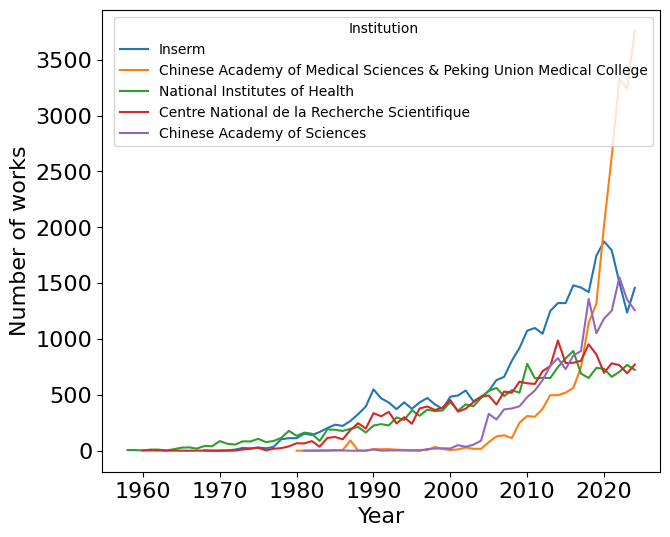

In [13]:
group_filtered = group_institutionsyears.filter( pl.col("institution_simple").is_in(top_institutions) )

group_agg = group_filtered.group_by(["institution_simple", "year"]).agg(
    pl.sum("count").alias("count")
).sort(["institution_simple", "year"])

palette = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728",
           "#9467bd", "#8c564b", "#e377c2", "#7f7f7f",
           "#bcbd22", "#17becf"]

unique_institutions = top_institutions
institution_colors = {inst: palette[i % len(palette)] for i, inst in enumerate(unique_institutions)}

plt.figure(figsize=(7.2, 6))

for inst in unique_institutions:
    df_inst = group_agg.filter(pl.col("institution_simple") == inst).sort("year")
    plt.plot(df_inst["year"].to_list(), df_inst["count"].to_list(),
             label=inst, color=institution_colors[inst])

plt.ylabel("Number of works", fontsize=16)
plt.xlabel("Year", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(title="Institution")
plt.show()


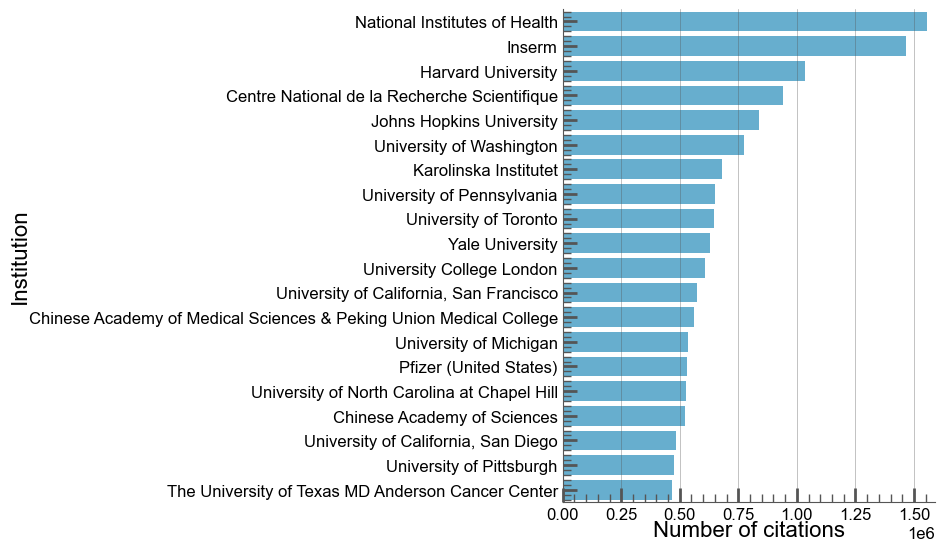

In [14]:
with aq.load_theme("scientific"):
    plt.figure(figsize=(4.8,6.4))
    sns.barplot(data = group_institutions_sum.head(n=20), x = "cited_by_count", y = "institution_simple", orient = "h")
    plt.ylabel("Institution",fontsize=16)
    plt.xlabel("Number of citations", fontsize=16)
    plt.show()

In [15]:
top_10_universities_names = [
    "Harvard University",
    "University College London",
    "University of Washington",
    "University of Michigan",
    "University of California, San Francisco",
    "University of Toronto",
    "Johns Hopkins University",
    "University of California, San Diego",
    "University of North Carolina at Chapel Hill",
    "University of Pennsylvania"
]

top_10_universities = (
    group_institutions_sum
    .filter(pl.col("institution_simple").is_in(top_10_universities_names))
    .with_columns([pl.lit("University").alias("kind")])
    .drop("institution_name")
)

In [16]:
test = works[["cited_by_count", "institutions_distinct_count"]].group_by(by = "institutions_distinct_count").len()
test

by,len
i64,u32
18,209
24,52
15,385
21,81
152,1
…,…
53,3
68,1
62,3


<Figure size 640x480 with 0 Axes>

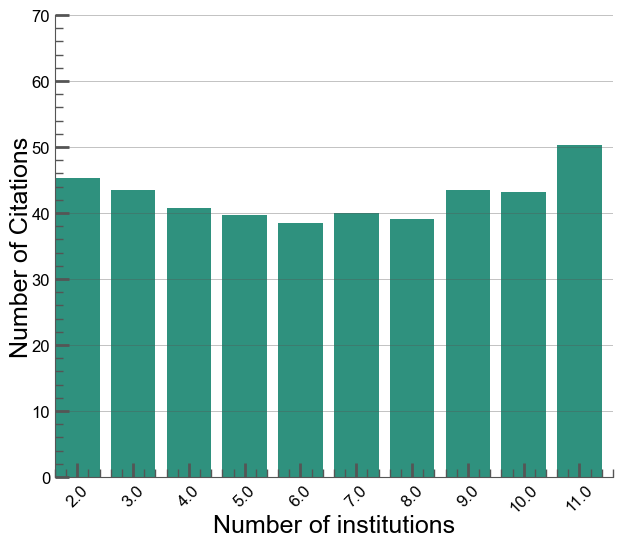

Mean authors count: 2.1066059727776882
Median authors count: 1.0


In [17]:
with aq.load_theme("scientific"):
    plt.figure(figsize=(7.2, 6))
    sns.barplot(data = group_Ninstitutions_mean, x = "institutions_distinct_count", y = "cited_by_count", color = sns.color_palette("viridis")[3])
    plt.xticks(rotation = 45)
    plt.xlim(0.6, 10.6)
    plt.ylim(0, 70)
    plt.xlabel("Number of institutions", fontsize=18)
    plt.ylabel("Number of Citations", fontsize=18)
    plt.show()

mean_value = works["institutions_distinct_count"].mean()
median_value = works["institutions_distinct_count"].median()
print(f"Mean authors count: {mean_value}")
print(f"Median authors count: {median_value}")

In [18]:
r_pearson, p_pearson = st.pearsonr(works["countries_distinct_count"], works["mncs"])
print(f"Pearson: r = {r_pearson:.3f}, p-value = {p_pearson:.3f}")

r_spearman, p_spearman = st.spearmanr(works["countries_distinct_count"], works["mncs"])
print(f"Spearman: rho = {r_spearman:.3f}, p-value = {p_spearman:.3f}")

Pearson: r = 0.061, p-value = 0.000
Spearman: rho = 0.148, p-value = 0.000


<Figure size 640x480 with 0 Axes>

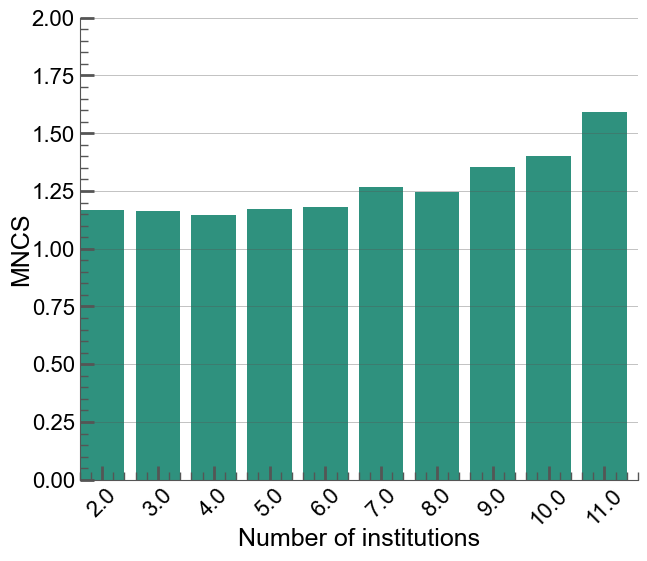

In [19]:
with aq.load_theme("scientific"):
    plt.figure(figsize=(7.2, 6))
    sns.barplot(data = group_Ninstitutions_mean, x = "institutions_distinct_count", y = "mncs", color = sns.color_palette("viridis")[3])
    plt.xticks(rotation = 45)
    plt.xlim(0.6, 10.6)
    plt.ylim(0, 2)
    plt.xlabel("Number of institutions", fontsize=18)
    plt.ylabel("MNCS", fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.show()

In [20]:
bigpharma_names = ["Johnson & Johnson",
                    "Roche", 
                    "Merck", # ! Merck & co != Merck KgaA
                    "Pfizer", 
                    "AbbVie",
                    "AstraZeneca",
                    "Novartis", 
                    "Bristol-Myers Squibb",
                    "Eli Lilly",
                    "Sanofi",
                    "Novo Nordisk",
                    "GlaxoSmithKline",
                    "Amgen",
                    "Takeda",
                    "Boehringer Ingelheim",
                    "Gilead Sciences",
                    "Bayer",
                    "Teva Pharmaceuticals",
                    "CSL",
                    "BMS"
                    ] 

starts_with_expression = pl.col("institution_simple").str.starts_with(bigpharma_names[0])
for name in bigpharma_names[1:]:
    starts_with_expression =  starts_with_expression | pl.col("institution_simple").str.starts_with(name)

bigpharma = (
        institutions
        .filter(
            starts_with_expression
        )
        .with_columns(
            (pl.when(pl.col("institution_simple").str.starts_with("Bristol-Myers Squibb")).then(pl.lit("Bristol-Myers Squibb"))
            .otherwise(pl.col("institution_simple").str.replace_all(r"[(–\-)]", ",").str.split(",").list.get(0).str.strip_chars()) #warning: \ before the - otherwise regex think it's a range of character like a-z=alphabet
            .alias("institution_simple"))
        
        )
        .with_columns(
            (pl.when(pl.col("institution_simple").is_in(["Merck & Co.", "Merck Serono", "Merck Canada Inc.", "Merck Institute for Science Education"])).then(pl.lit("Merck"))
            .when(pl.col("institution_simple").is_in(["Pfizer-University of Granada-Junta de Andalucía Centre for Genomics and Oncological Research"])).then(pl.lit("Pfizer"))
            .when(pl.col("institution_simple").is_in(["Novartis Institutes for BioMedical Research", "Novartis Foundation"])).then(pl.lit("Novartis"))
            .when(pl.col("institution_simple").is_in(["Roche Pharma AG"])).then(pl.lit("Roche"))
            .when(pl.col("institution_simple").is_in(["Novo Nordisk Foundation"])).then(pl.lit("Novo Nordisk"))
            .otherwise(pl.col("institution_simple"))
            .alias("institution_simple"))
        
    )
)

bigpharma

year,index_work,cited_by_count,mncs,institution_pos,institution_name,count,institution_simple,cumulative_count,cumulative_citations,cumulative_mncs,mean_past_mncs_institutions
i64,u32,i64,f64,str,str,i8,str,i64,i64,f64,f64
1959,7227,16,0.463768,"""institution_1""","""['Roche (Switzerland)', 'https…",1,"""Roche""",0,0,0.0,1.0
1960,7666,24,0.857821,"""institution_1""","""['Roche (Switzerland)', 'https…",1,"""Roche""",1,16,0.463768,0.463768
1960,7666,24,0.857821,"""institution_2""","""['Roche (Switzerland)', 'https…",1,"""Roche""",2,40,1.321589,0.660794
1960,7666,24,0.857821,"""institution_3""","""['Roche (Switzerland)', 'https…",1,"""Roche""",3,64,2.179409,0.72647
1961,8042,25,0.656194,"""institution_1""","""['Merck & Co., Inc., Rahway, N…",1,"""Merck""",0,0,0.0,1.0
…,…,…,…,…,…,…,…,…,…,…,…
2024,689358,0,0.0,"""institution_3""","""['Pfizer (United States)', 'ht…",1,"""Pfizer""",8748,529730,13283.227249,1.51843
2024,689358,0,0.0,"""institution_4""","""['Pfizer (United States)', 'ht…",1,"""Pfizer""",8749,529730,13283.227249,1.518257
2024,689358,0,0.0,"""institution_6""","""['Pfizer (United States)', 'ht…",1,"""Pfizer""",8750,529730,13283.227249,1.518083


In [21]:
errors = [
    "Rochester General Hospital",
    "Rochester Institute of Technology",
    "Bayero University Kano",
    "Bayerisches Landesamt für Gesundheit und Lebensmittelsicherheit"
]

group_bigpharma = (
    bigpharma
    .drop(["institution_name", "institution_pos"])
    .group_by(by = "institution_simple", maintain_order=True)
    .sum()
    .sort("cited_by_count", descending=True)
    .filter(~(pl.col("by").is_in(errors)))
)

group_bigpharma = group_bigpharma.with_columns(
    kind = pl.lit("Company"),
    institution_simple = pl.col("by")
).drop(["by", "index_work", "year"])

group_bigpharma

cited_by_count,mncs,count,institution_simple,cumulative_count,cumulative_citations,cumulative_mncs,mean_past_mncs_institutions,kind
i64,f64,i64,str,i64,i64,f64,f64,str
673897,16583.053673,10901,"""Pfizer""",39375148,2917388143,6.3850e7,17934.946859,"""Company"""
549406,13565.785347,9391,"""Merck""",28047765,1983509339,4.6329e7,16297.813371,"""Company"""
545202,11950.972966,8361,"""GlaxoSmithKline""",10304363,891726066,1.7308e7,14010.253984,"""Company"""
489594,11706.454228,7847,"""Novartis""",11257293,780051884,1.7161e7,12236.333438,"""Company"""
437643,10156.387348,7038,"""Eli Lilly""",19123498,1236202849,2.8077e7,9967.920431,"""Company"""
…,…,…,…,…,…,…,…,…
554,15.3286,10,"""Novo Nordisk Foundation Center…",45,2717,70.504247,15.1178,"""Company"""
114,2.84951,1,"""Rochester Institute of Technol…",0,0,0.0,1.0,"""Company"""
53,1.108824,1,"""Boehringer Ingelheim Foundatio…",0,0,0.0,1.0,"""Company"""


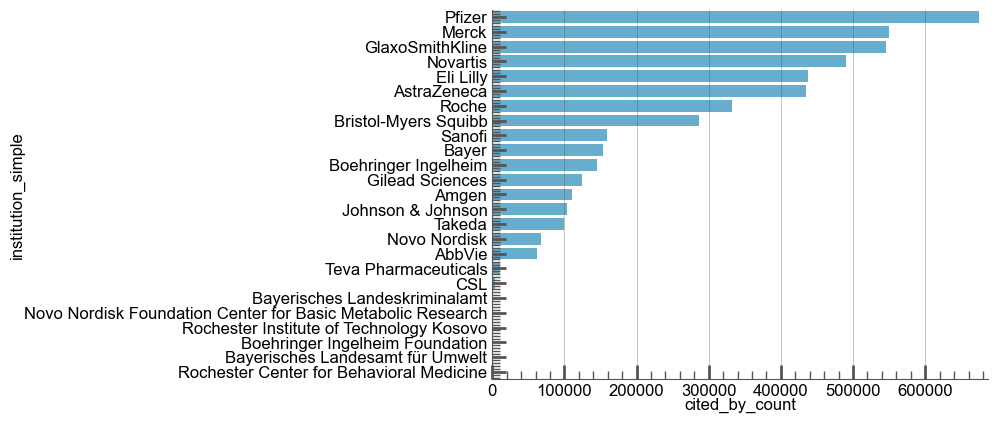

In [22]:
with aq.load_theme("scientific"):
    sns.barplot(data = group_bigpharma, x = "cited_by_count", y = "institution_simple", orient = "h",  legend = True)
    #plt.xticks(rotation = 90)
    plt.show()

In [23]:
group_national_institutions = (
    group_institutions_sum
    .head(4)  # 3 top national institutions but without Harvard
    .filter(pl.col("institution_simple") != "Harvard University")
    .with_columns([pl.lit("National Institution").alias("kind")])
    .drop("institution_name")
)
impact_universities = top_10_universities["cited_by_count"].sum()/top_10_universities["count"].sum()
impact_bigpharma = group_bigpharma["cited_by_count"].sum()/group_bigpharma["count"].sum()
impact_national = group_national_institutions["cited_by_count"].sum()/ group_national_institutions["count"].sum()
print(impact_national)
print(impact_universities)
print(impact_bigpharma)

51.89484697881245
58.98014398924503
57.43421935669431


In [24]:
top_10_universities = (
    group_institutions_sum
    .filter(pl.col("institution_simple").is_in(top_10_universities_names))
    .with_columns([pl.lit("University").alias("kind")])
    .drop("institution_name")
)


group_bigpharma = group_bigpharma.select(top_10_universities.columns)

top_20 = pl.concat([
    top_10_universities.head(7),
    group_bigpharma.head(6),
    group_national_institutions
], how="vertical").sort("cited_by_count", descending=True)


C:\Users\noahr\AppData\Local\Temp\ipykernel_1800\1976038920.py:3: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.barplot(data = top_20, x = "cited_by_count", y = "institution_simple", orient = "h", hue="kind", palette = palette, legend = True)


<Figure size 640x480 with 0 Axes>

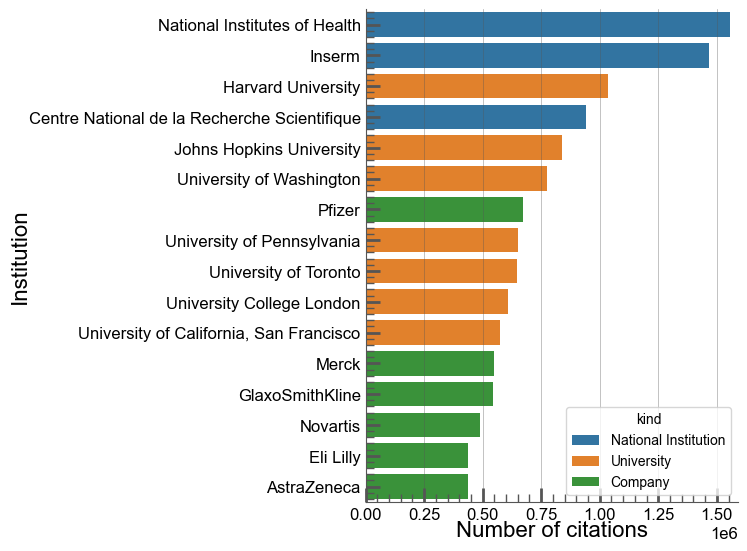

In [25]:
with aq.load_theme("scientific"):
    plt.figure(figsize=(4.8,6.4))
    sns.barplot(data = top_20, x = "cited_by_count", y = "institution_simple", orient = "h", hue="kind", palette = palette, legend = True)
    plt.xlabel("Number of citations", fontsize = 16)
    plt.ylabel("Institution", fontsize=16)
    plt.show()

In [26]:
means_yearly_citations = [works[f"cited_by_count_{i}"].mean() for i in range(2012, 2025)]

new_studies = works.filter(pl.col("year") == 2012)
means_2012_yearly_citations = [new_studies[f"cited_by_count_{i}"].mean() for i in range(2012, 2025)]

years = range(13)
years_2012 = range(2012, 2025)

list_means_yearly_citations = []
for year in years:
    new_studies = works.filter(pl.col("year") == 2012 + year)
    list_means_yearly_citations.append([new_studies[f"cited_by_count_{i}"].mean() for i in range(2012 + year, 2025)])

<Figure size 640x480 with 0 Axes>

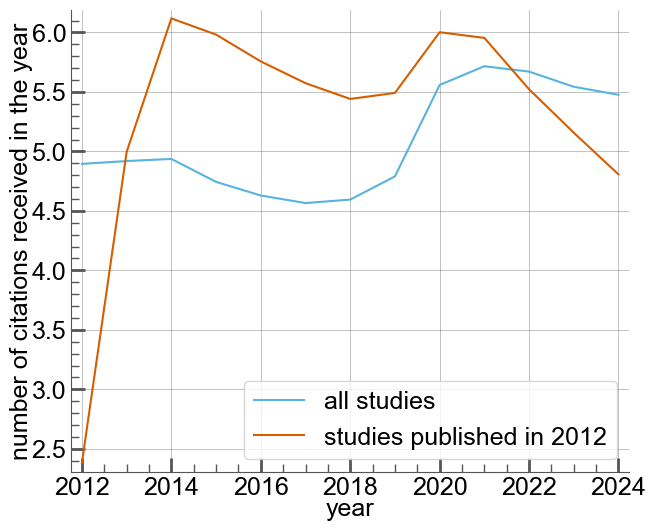

In [27]:
with aq.load_theme("scientific"):
    plt.figure(figsize=(7.2, 6))
    sns.lineplot(x = years_2012, y =  means_yearly_citations, label = "all studies")
    sns.lineplot(x = years_2012, y =  means_2012_yearly_citations, label = "studies published in 2012")
    plt.xlabel("year", fontsize=18)
    plt.ylabel("number of citations received in the year", fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.legend(fontsize=18)
    plt.show()

In [28]:
number_studies_per_year = (
    works
    .with_columns(pl.lit(1).alias("count"))
    .select(["year", "count"])
    .group_by("year")
    .sum()
    .sort("year")
)

number_studies_per_year_series = pd.Series(
    number_studies_per_year["count"].to_list(),
    index=number_studies_per_year["year"].to_list()
)
number_studies_per_year_series = number_studies_per_year_series.reindex(years_2012, fill_value=0)

number_studies_per_year_series = (number_studies_per_year_series - number_studies_per_year_series.min()) / \
                                 (number_studies_per_year_series.max() - number_studies_per_year_series.min())

means_yearly_citations = []
for year in years_2012:
    new_studies = works.filter(pl.col("year") == year)
    mean_cites = [new_studies[f"cited_by_count_{i}"].mean() for i in range(year, 2025)]
    means_yearly_citations.append(sum(mean_cites)/len(mean_cites)) 

means_yearly_citations_series = pd.Series(means_yearly_citations, index=years_2012)
means_yearly_citations_series = (means_yearly_citations_series - means_yearly_citations_series.min()) / \
                                (means_yearly_citations_series.max() - means_yearly_citations_series.min())


<Figure size 640x480 with 0 Axes>

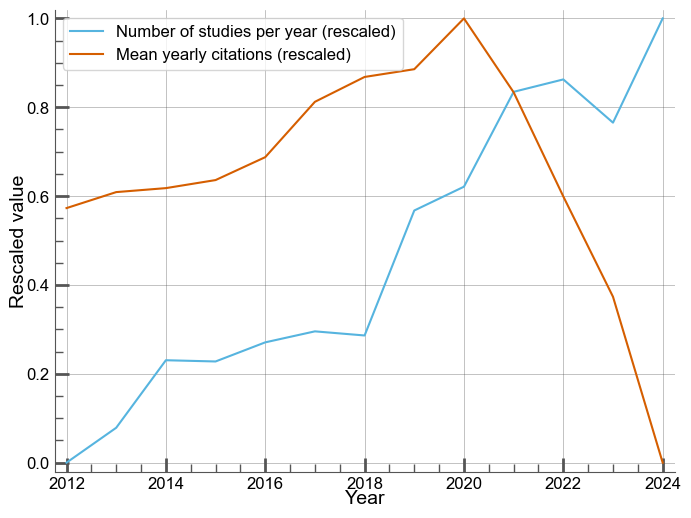

In [29]:
with aq.load_theme("scientific"):
    fig, ax = plt.subplots(figsize=(8,6))
    sns.lineplot(x=years_2012, y=number_studies_per_year_series.values, label="Number of studies per year (rescaled)", ax=ax)
    sns.lineplot(x=years_2012, y=means_yearly_citations_series.values, label="Mean yearly citations (rescaled)", ax=ax)
    ax.set_xlabel("Year", fontsize=14)
    ax.set_ylabel("Rescaled value", fontsize=14)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    ax.legend(fontsize=12)
    plt.show()


<Figure size 640x480 with 0 Axes>

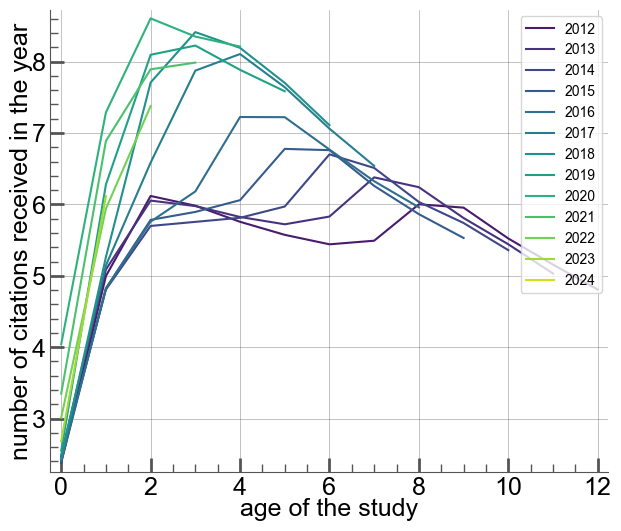

In [30]:
with aq.load_theme("scientific"):
    plt.figure(figsize=(7.2, 6))
    for i in range(13):
        y = list_means_yearly_citations[i]
        sns.lineplot(x = years[:len(y)], y = y, label = f"{2012 + i}", color = sns.set_palette("viridis", n_colors = 13))
    plt.xlabel("age of the study", fontsize=18)
    plt.ylabel("number of citations received in the year", fontsize=18)
    plt.legend()
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.show()

<Figure size 640x480 with 0 Axes>

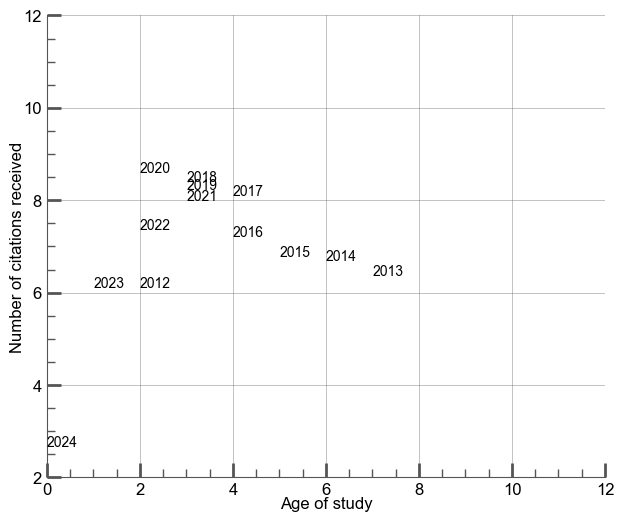

In [31]:
plt.figure(figsize=(7.2, 6))

for i in range(13):
    liste = pd.Series(list_means_yearly_citations[i])
    x = liste.argmax()
    y = liste.max()
    plt.text(x=x, y=y, s=f"{2012 + i}", fontweight=50)
plt.xlabel("Age of study", fontsize=12)  # explains x
plt.ylabel("Number of citations received", fontsize=12)   
plt.xlim(0,12)
plt.ylim(2,12)
plt.show()


In [32]:
new_studies = works.filter(pl.col("year") == 2012)


top_studies = new_studies.sort("cited_by_count", descending=True).with_row_index()
superstars = top_studies.filter(pl.col("index")<=85)
stars = top_studies.filter((pl.col("index")>85) & (pl.col("index")<=852))
usual = top_studies.filter(pl.col("index")>852)

superstars_2012_yearly_citations = pd.Series([superstars[f"cited_by_count_{i}"].mean() for i in range(2012, 2025)])
stars_2012_yearly_citations = pd.Series([stars[f"cited_by_count_{i}"].mean() for i in range(2012, 2025)])
usual_2012_yearly_citations = pd.Series([usual[f"cited_by_count_{i}"].mean() for i in range(2012, 2025)])

superstars_2012_yearly_citations = (superstars_2012_yearly_citations - superstars_2012_yearly_citations.min())/(superstars_2012_yearly_citations.max() - superstars_2012_yearly_citations.min())
stars_2012_yearly_citations = (stars_2012_yearly_citations - stars_2012_yearly_citations.min())/(stars_2012_yearly_citations.max() - stars_2012_yearly_citations.min())
usual_2012_yearly_citations = (usual_2012_yearly_citations - usual_2012_yearly_citations.min()) / (usual_2012_yearly_citations.max() - usual_2012_yearly_citations.min())

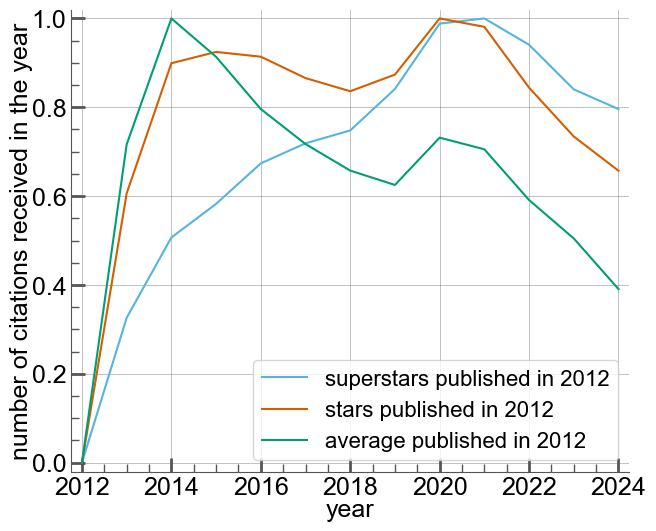

In [33]:
with aq.load_theme("scientific"):
    plt.figure(figsize=(7.2, 6))
    sns.lineplot(x = years_2012, y =  superstars_2012_yearly_citations, label = "superstars published in 2012")
    sns.lineplot(x = years_2012, y =  stars_2012_yearly_citations, label = "stars published in 2012")
    sns.lineplot(x = years_2012, y =  usual_2012_yearly_citations, label = "average published in 2012")
    plt.xlabel("year", fontsize=18)
    plt.ylabel("number of citations received in the year", fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.legend(fontsize=16)
    plt.show()

In [34]:
mean_citations = (
    works
    .filter(pl.col("year").is_between(2012, 2024))
    .group_by("year", maintain_order=True)
    .agg(pl.mean("cited_by_count"))
    .sort("year")
)
list_mean_citations = mean_citations.select("cited_by_count").to_series()
list_citation_attention = [ (list_mean_citations[i] - np.cumsum(list_means_yearly_citations[i]))/np.sum(list_means_yearly_citations[i]) for i in range(13)]
list_citation_attention

[array([ 0.65232449,  0.58010594,  0.49167551,  0.40521276,  0.32200892,
         0.24144724,  0.16280313,  0.08342784, -0.00332225, -0.08938715,
        -0.16920992, -0.24375097, -0.31322641]),
 array([ 0.64852967,  0.5712829 ,  0.47937423,  0.38863295,  0.30021029,
         0.21334248,  0.12482907,  0.0279807 , -0.06677312, -0.1549715 ,
        -0.23758541, -0.31398243]),
 array([ 0.59645142,  0.51742493,  0.42374875,  0.32913379,  0.23358267,
         0.1354333 ,  0.02527433, -0.08175277, -0.18094672, -0.27529879,
        -0.36339567]),
 array([ 0.64911769,  0.5631633 ,  0.46014874,  0.35514853,  0.24721374,
         0.12648729,  0.00608082, -0.10541184, -0.20985139, -0.30835155]),
 array([ 0.66699477,  0.5754388 ,  0.46610972,  0.34876134,  0.21162158,
         0.07452222, -0.05396475, -0.17403647, -0.28716306]),
 array([ 0.72939031,  0.62935148,  0.5013297 ,  0.34826193,  0.19068121,
         0.04213985, -0.09512274, -0.22224814]),
 array([ 0.82796871,  0.7155737 ,  0.55095753,  0

<Figure size 640x480 with 0 Axes>

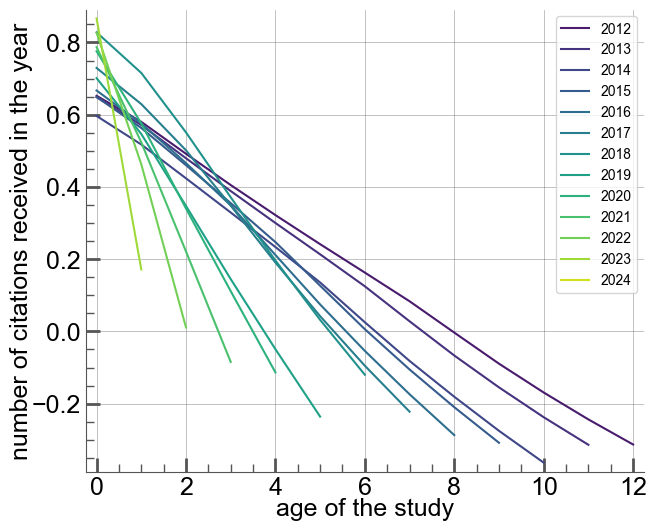

In [35]:
with aq.load_theme("scientific"):
    plt.figure(figsize=(7.2, 6))
    for i in range(13):
        y = list_citation_attention[i]
        sns.lineplot(x = years[:len(y)], y = y, label = f"{2012 + i}", color = sns.set_palette("viridis", n_colors = 13))
    plt.xlabel("age of the study", fontsize=18)
    plt.ylabel("number of citations received in the year", fontsize=18)
    plt.legend()
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.show()